In [7]:
import base64
import requests

import subprocess
from getpass import getpass

password = getpass()
cmd = ["openssl", "enc", "-d", "-aes-256-cbc", "-in", "openai-key.enc", "-pass", f"pass:{password}"]
api_key = subprocess.run(cmd, capture_output=True, text=True).stdout.strip("\n")

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

 ········


In [8]:
api_key = ""
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

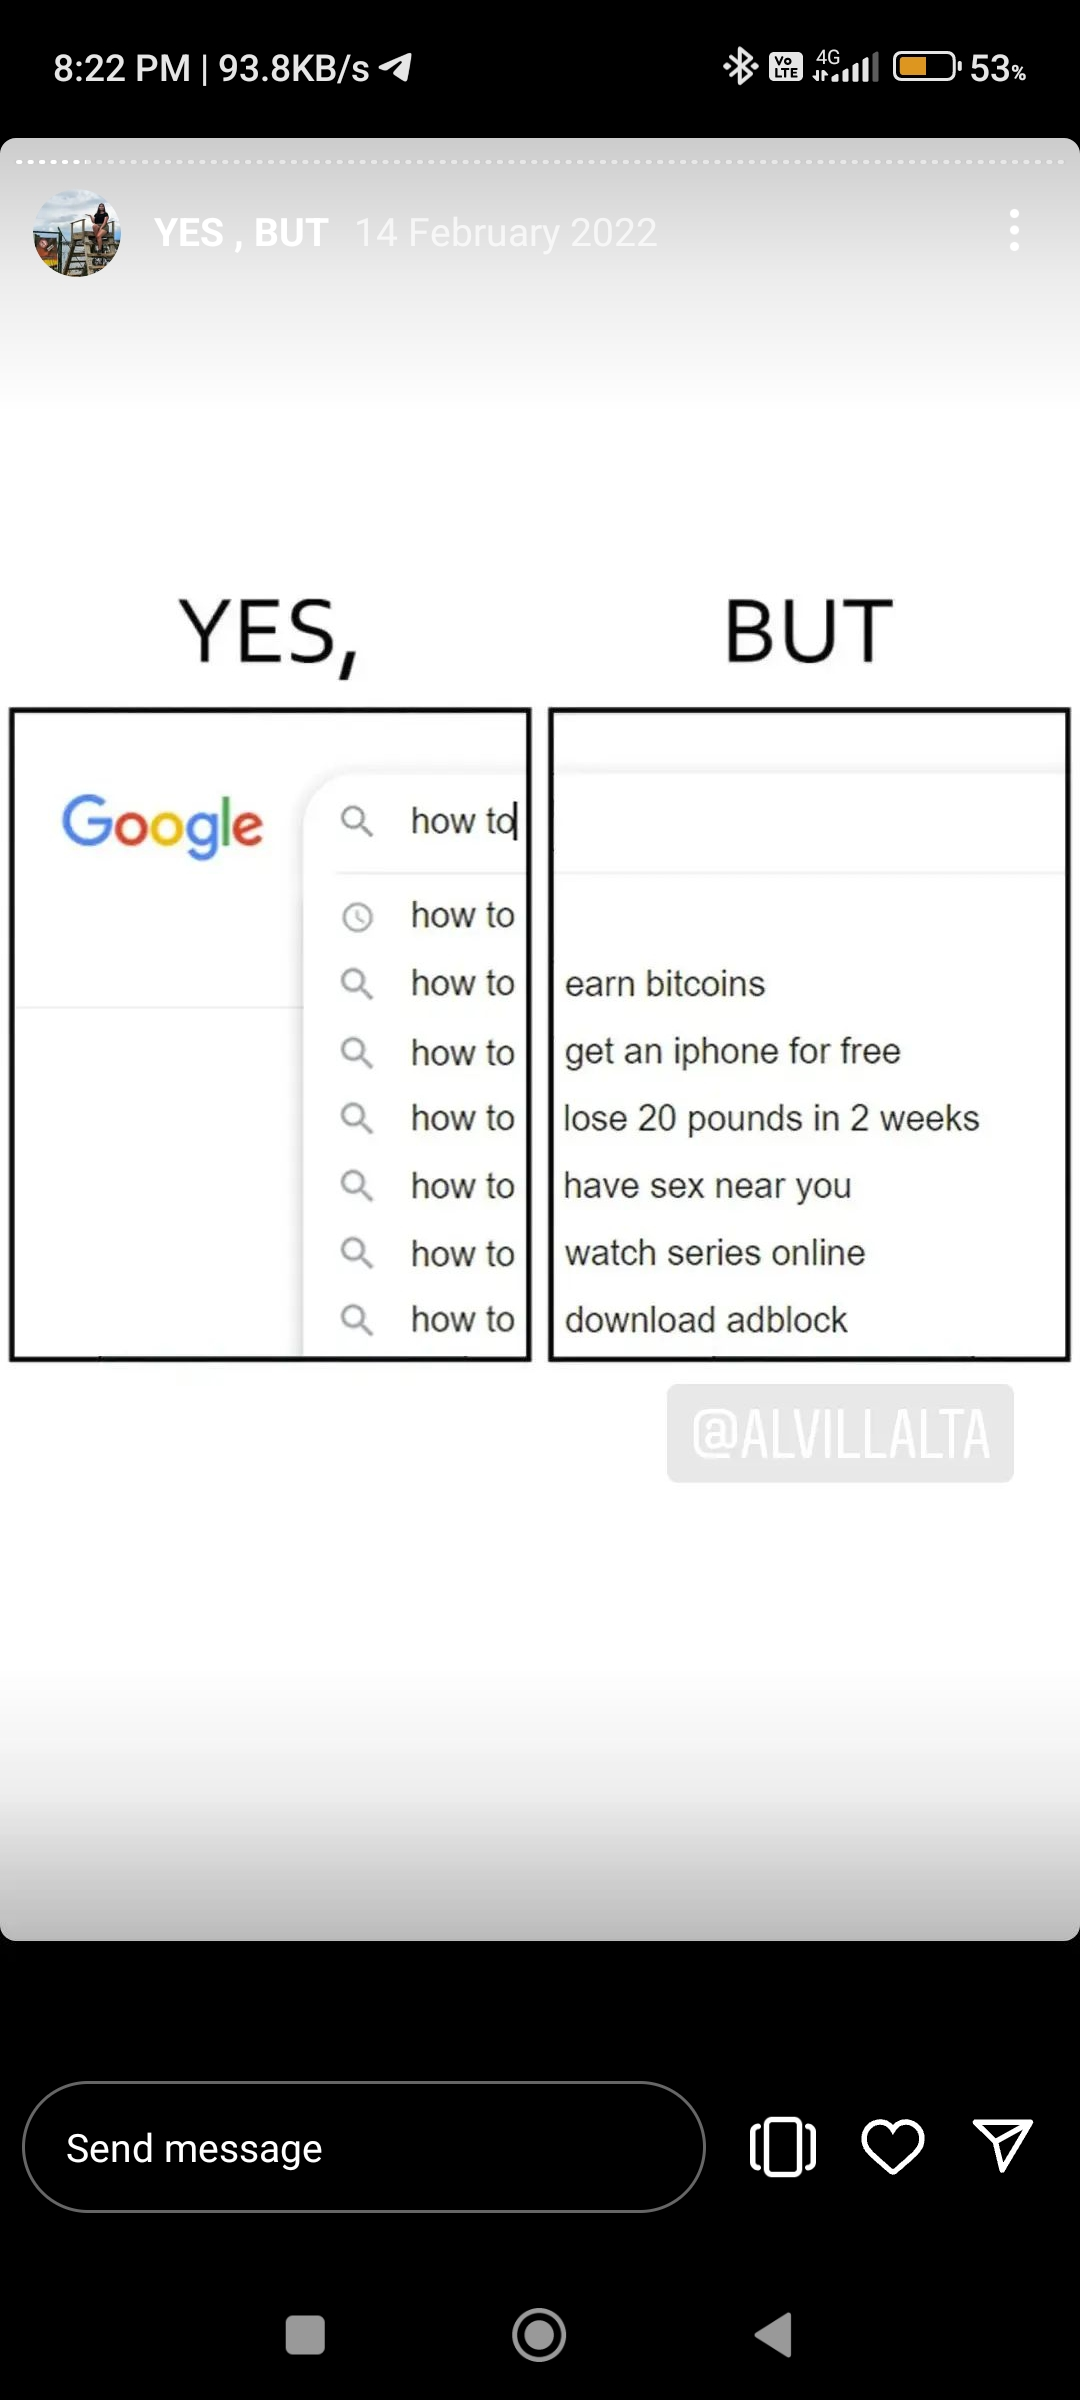

{'id': 'chatcmpl-9SlrYbfHF3mU1TySgD2LReHzACiYj', 'object': 'chat.completion', 'created': 1716644196, 'model': 'gpt-4-1106-vision-preview', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The image is humorous because it juxtaposes two contrasting approaches to using Google\'s search: one side suggesting productive and self-improvement searches like "how to tie a tie" or "how to talk to a girl," while the other side represents more questionable or less productive searches, such as "how to earn bitcoins" or "how to watch series online." The humor lies in the implied message that while the internet can be a tool for learning and growth, it is often used for more trivial or dubious pursuits. The "YES, BUT" template satirically acknowledges this duality.'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 113, 'completion_tokens': 118, 'total_tokens': 231}, 'system_fingerprint': None}


({'prompt_tokens': 113, 'completion_tokens': 118, 'total_tokens': 231},
 'The image is humorous because it juxtaposes two contrasting approaches to using Google\'s search: one side suggesting productive and self-improvement searches like "how to tie a tie" or "how to talk to a girl," while the other side represents more questionable or less productive searches, such as "how to earn bitcoins" or "how to watch series online." The humor lies in the implied message that while the internet can be a tool for learning and growth, it is often used for more trivial or dubious pursuits. The "YES, BUT" template satirically acknowledges this duality.')

In [9]:
prompt = '''You are an AI expert in detecting humour or satire. You detect and describe satire in user's image input and then classify it as either funny (Y) or not funny (N).
            ### IMPORTANT: Answer Y ONLY if the image is VERY obviously satirical (or funny).
            ###Output format: This image contains <brief description>. Thus, the answer is <exactly only Y or N>.'''
prompt = "Why is this image funny/satirical? Explain in about 50-70 words"
def generate(image_path, verbose = False):
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    payload = {
      "model": "gpt-4-vision-preview",
      "messages": [
        {
            "role": "system",
            "content": [{"type": "text", "text": prompt}]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
                  "detail": "low"
              }
            }
          ]
        }
      ],
      "max_tokens": 256,
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload).json()
    if verbose:
        from PIL import Image
        image = Image.open(image_path)
        display(image)
        print(response)
    if "usage" not in response and "error" in response:
        raise Exception(response["error"]["message"])
    return response["usage"], response["choices"][0]["message"]["content"]

generate("images_real/Screenshot_2024-05-23-20-22-16-966_com.instagram.android.jpg", True)

In [6]:
import os, json
from tqdm import tqdm
import random

## schema [{"image_path": <>, "prompt": <>, "usage": {"prompt_tokens": ...}}]
with open("gpt4-usages.json", "r") as f:
    usages = json.load(f)
    total_usage = sum(x["usage"]["total_tokens"] for x in usages)

outpath = "outputs/detection/gpt4-vision-cot-real.json"
inpaths = ["images_real"]

try:
    with open(outpath, "r") as f:
        outputs = json.load(f)
except FileNotFoundError:
    print("starting from zero")
    outputs = {}

def get_pred(output):
    if not output:
        return ""
    return output[-2]

def is_correct(pred, folder):
    if not pred:
        return False
    return (pred=="Y" and "negative" not in folder) or (pred=="N" and "negative" in folder)

current_usage = 0
total, correct, adhering, y = 0,0,0,0
files = sum(([os.path.join(folder, file) for file in os.listdir(folder) if file[-3:]=="jpg"] for folder in inpaths),[])   
random.Random(42).shuffle(files)
pbar = tqdm(files)
for filepath in pbar:
    folder,file = filepath.split('/')
    if filepath in outputs and outputs[filepath]:
        total+=1
        pred = get_pred(outputs[filepath])
        correct += 1 if is_correct(pred,folder) else 0
        adhering += 1 if pred in ["Y", "N"] else 0
        y += 1 if pred=="Y" else 0
        pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage, "folder": folder, "total": total, "accuracy": correct/total, "adherance": adhering/total, "y%": y/adhering if adhering>0 else 0})
        continue
    try:
        usage, output = generate(filepath)
    except Exception as e:
        print("Caught exception: ", str(e))
        print("Could not do: ",filepath)
        usage = {'prompt_tokens': 0, 'completion_tokens': 0, 'total_tokens': 0}
        output = ""

    outputs[filepath] = output
    with open(outpath, "w") as f:
        json.dump(outputs, f, indent=4)

    usages.append({"image_path":filepath, "prompt": prompt, "usage": usage})
    with open("gpt4-usages.json", "w") as f:
        json.dump(usages, f, indent=2)
    
    current_usage+=usage["total_tokens"]
    total_usage+=usage["total_tokens"]

    total+=1
    pred = get_pred(outputs[filepath])
    correct += 1 if is_correct(pred,folder) else 0
    adhering += 1 if pred in ["Y", "N"] else 0
    y += 1 if pred=="Y" else 0
    pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage, "folder": folder, "total": total, "accuracy": correct/total, "adherance": adhering/total, "y%": y/adhering if adhering>0 else 0})

with open(outpath, "w") as f:
    json.dump(outputs, f, indent=4)  

starting from zero


100%|█| 119/119 [10:37<00:00,  5.36s/it, current_usage=28584, total_usage=1888722, folder=images_real, total=119, accuracy=0.933, adherance=1, y


In [11]:
import os, json
from tqdm import tqdm

## schema [{"image_path": <>, "prompt": <>, "usage": {"prompt_tokens": ...}}]
with open("gpt4-usages.json", "r") as f:
    usages = json.load(f)
    total_usage = sum(x["usage"]["total_tokens"] for x in usages)

outpath = "outputs/annotations/images_real/whyfunny/gpt4-vision-whyfunny.json"
inpath = "images_real"
try:
    with open(outpath, "r") as f:
        outputs = json.load(f)
except FileNotFoundError:
    print("starting from zero")
    outputs = {}

current_usage = 0
#files = [x for x in os.listdir("images_split") if "BUT" in x]
#redo_files = [path for path,output in outputs.items() if "Rate limit reach" in output]
#print(f"Redoing {len(redo_files)} files")
files = os.listdir(inpath)
redo_files = []
pbar = tqdm(files)
for filename in pbar:
    if filename in outputs and outputs[filename]:
        continue
    try:
        usage, output = generate(os.path.join(inpath, filename))
    except Exception as e:
        print("Caught exception: ", str(e))
        print("Could not do: ",filename)
        usage = {'prompt_tokens': 0, 'completion_tokens': 0, 'total_tokens': 0}
        output = ""

    outputs[filename] = output
    with open(outpath, "w") as f:
        json.dump(outputs, f, indent=4)

    usages.append({"image_path":filename, "prompt": prompt, "usage": usage})
    with open("gpt4-usages.json", "w") as f:
        json.dump(usages, f, indent=2)
    
    current_usage+=usage["total_tokens"]
    total_usage+=usage["total_tokens"]
    pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage})

with open(outpath, "w") as f:
    json.dump(outputs, f, indent=4)

100%|█████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 1160.24it/s, current_usage=0, total_usage=1939835]

Caught exception:  [Errno 21] Is a directory: 'images_real/.ipynb_checkpoints'
Could not do:  .ipynb_checkpoints


In [ ]:
# whyfunny: 53930
# punchline: 63560
# left: ~60000
# right: ~60000

In [ ]:
positives - 1084:
    1. original - 283
    2. second_round - 302
    3. third_round - 499
negatives - 1463:
    1. second_round - 547
    2. third_round - 916